## 1. Import Modules

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU
import pandas as pd    
import random
import numpy as np

## 2. Metrics and Losses

In [2]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

## 3. Keras model and helper functions

In [3]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [4]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [5]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

In [6]:
def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [7]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [8]:
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    
#     pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
#     # DownRes 5, convolution only
#     conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

#     # Upsampling layers
#     # UpRes 6, attention gated concatenation + upsampling + double residual convolution
#     gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
#     att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
#     up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
#     up_16 = layers.concatenate([up_16, att_16], axis=axis)
#     up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    gating_32 = gating_signal(conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [9]:
input_shape = (64, 64, 3)
model = Attention_ResUNet(input_shape)

In [10]:
model.summary()

Model: "AttentionResUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________

In [11]:
att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=tf.keras.losses.BinaryCrossentropy,
              metrics=['accuracy', jacard_coef])

### 3. Load data

The images are stored in multiple directories. The training images/inputs are stored in the 10k folder under train, test and val. The masks corrosponding to these images are stored in colormaps under train and val (in the 100k folder).

**Folder paths for images**:
* ./data/bdd100k_images_10k/bdd100k/images/10k/train
* ./data/bdd100k_images_10k/bdd100k/images/10k/test
* ./data/bdd100k_images_10k/bdd100k/images/10k/val
</br>

**Folder paths for masks**:
* ./data/drivable_labels/bdd100k/labels/drivable/colormaps/train
* ./data/drivable_labels/bdd100k/labels/drivable/colormaps/val
</br></br>



In [12]:
image_paths = os.listdir('./data/bdd100k_images_10k/bdd100k/images/10k/train')
image_paths += os.listdir('./data/bdd100k_images_10k/bdd100k/images/10k/test')
image_paths += os.listdir('./data/bdd100k_images_10k/bdd100k/images/10k/val')

In [13]:
image_paths = [i.split('.')[0] for i in image_paths]

In [14]:
train_labels = os.listdir('./data/drivable_labels/bdd100k/labels/drivable/colormaps/train')
train_labels += os.listdir('./data/drivable_labels/bdd100k/labels/drivable/colormaps/val')

In [15]:
train_labels = [i.split('.')[0] for i in train_labels]

In [16]:
count = 0
for i in image_paths:
    if i not in train_labels:
        count += 1
    else:
        print(i)
        break

print("count = ", count)

00054602-3bf57337
count =  1


In [17]:
import cv2

In [18]:
core = cv2.imread('./data/bdd100k_images_10k/bdd100k/images/10k/train/00054602-3bf57337.jpg')

In [132]:
img = cv2.imread('./data/drivable_labels/bdd100k/labels/drivable/colormaps/train/00054602-3bf57337.png')

In [133]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

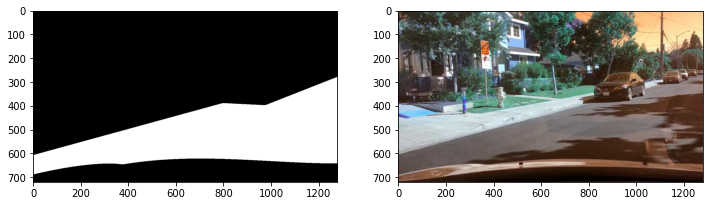

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(core)
plt.show()

In [22]:
from tensorflow.keras.utils import Sequence

In [25]:
import glob

In [43]:
train_paths = glob.glob(f"{os.path.join('./data/bdd100k_images_10k/bdd100k/images/10k', 'train')}/*.jpg")
train_paths += glob.glob(f"{os.path.join('./data/bdd100k_images_10k/bdd100k/images/10k', 'test')}/*.jpg")
train_paths += glob.glob(f"{os.path.join('./data/bdd100k_images_10k/bdd100k/images/10k', 'val')}/*.jpg")

In [ ]:
train_paths = [i.split('.jpg')[0] for i in train_paths]

In [53]:
ids = [train_paths[i].split('\\')[-1] for i in range(len(train_paths))]

In [78]:
test_paths = glob.glob(f"{os.path.join('./data/drivable_labels/bdd100k/labels/drivable/colormaps', 'train')}/*.png")
test_paths += glob.glob(f"{os.path.join('./data/drivable_labels/bdd100k/labels/drivable/colormaps', 'val')}/*.png")

In [80]:
test_paths = [i.split('.png')[0] for i in test_paths]

In [82]:
valid_ids = [i for i in [*set([i.split('\\')[-1] for i in test_paths])] if i in ids]    

In [ ]:
test_paths = [i for i in test_paths if i.split('\\')[-1] in valid_ids]

In [85]:
len(test_paths)

3430

In [86]:
train_paths = [i for i in train_paths if i.split('\\')[-1] in valid_ids]

In [87]:
len(train_paths)

3430

In [94]:
def keyFunc(x):
    return x.split('\\')[-1]

In [95]:
train_paths.sort(key = keyFunc)

In [96]:
test_paths.sort(key = keyFunc)

In [97]:
count = 0
for idx, i in enumerate(train_paths):
    if test_paths[idx].split('\\')[-1] != i.split('\\')[-1]:
        count += 1
print(count)

0


In [99]:
test_paths[0]

'./data/drivable_labels/bdd100k/labels/drivable/colormaps\\train\\00054602-3bf57337'

In [100]:
train_paths[0]

'./data/bdd100k_images_10k/bdd100k/images/10k\\train\\00054602-3bf57337'

In [152]:
class LoadData(Sequence):
    def __init__(self, trainPaths, testPaths, batchSize):       
        self.trainPaths = trainPaths
        self.testPaths = testPaths
        self.batchSize = batchSize
    
    def __len__(self):
        return int(np.ceil(len(self.trainPaths)/self.batchSize))
    
    def readImage(self, path):
        '''
        INPUTS:
            path: the file path to the image that we need to read
            
        OUTPUTS:
            we read the image in the given path and normalize it by dividing it by 255.0
        '''
        return cv2.imread(path)/255.0
    
    def grayScale(self, image):
        image *= 255.0 
        grayValue = 0.07 * image[:,:,2] + 0.72 * image[:,:,1] + 0.21 * image[:,:,0]
        gray_img = grayValue.astype(np.uint8)
        return gray_img
    
    def __getitem__(self, idx):
        x_paths = self.trainPaths[idx * self.batchSize : (idx + 1) * self.batchSize]
        y_paths = self.testPaths[idx * self.batchSize : (idx + 1) *self.batchSize]
        
        x_paths = [i + '.jpg' for i in x_paths]
        y_paths = [i + '.png' for i in y_paths]
        
        print(y_paths[0])
        
        x = np.array(list(map(self.readImage, x_paths)))
        y = np.array(list(map(self.readImage, y_paths)))
        y = np.array(list(map(self.grayScale, y)))
               
        return x, y
        

In [153]:
testing = LoadData(train_paths, test_paths, 4).__iter__()

In [154]:
for i, j in testing:
    print(i.shape)
    print(j.shape)
    break

./data/drivable_labels/bdd100k/labels/drivable/colormaps\train\00054602-3bf57337.png
(4, 720, 1280, 3)
(4, 720, 1280)


In [143]:
j[0].shape

(720, 1280, 3)

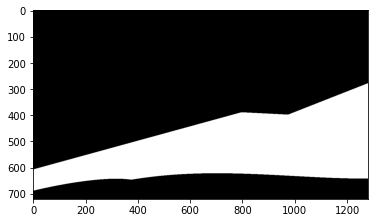

In [155]:
plt.imshow(j[0], cmap='gray')

### 4. Training

In [ ]:
def apply_gradient(optimizer, model, loss_fn, x, y):
    losses = []
    with tf.GradientTape() as tape:
        logits = model(x)
#         loss_value = loss_fn(prediction = logits[0], target = y[0], anchors = anchors[0]
#                             ) + loss_fn(prediction = logits[1], target = y[1], anchors = anchors[1]
#                                        ) + loss_fn(prediction = logits[2], target = y[2], anchors = anchors[2])

        loss_value = 0 # add a loss function here
        
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    loss_value = np.mean(loss_value)
    return loss_value

In [ ]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    losses = []
    for batch_idx, (x, y) in enumerate(loop):

        losses.append(apply_gradient(optimizer, model, RUNLoss(), x, y))

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)

In [ ]:
def main(EPOCHS):
    model = Attention_ResUNet(input_shape = (720, 1280, 3))
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = config.LEARNING_RATE
    )
    
    loss_fn = tf.keras.losses.BinaryCrossentropy()
        
    train_dataloader = LoadData(train_paths, test_paths, 64).__iter__()
    
    for epoch in range(EPOCHS):
        train_fn(train_dataloader, model, optimizer, loss_fn, scaled_anchors)

    return model

### 5. Testing

In [ ]:
model_path = "models/RA_Unet.hdf5"

model = tf.keras.models.load_model(model_path, compile=False)

In [ ]:
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
IoU_values = []

for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)

In [ ]:
df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    